# Install YOLOv5 & Dependencies

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 10041, done.
remote: Total 10041 (delta 0), reused 0 (delta 0), pack-reused 10041
Receiving objects: 100% (10041/10041), 10.38 MiB | 25.56 MiB/s, done.
Resolving deltas: 100% (6964/6964), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 13.4 MB/s 
Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16160MB, multi_processor_count=80)


# Download Data Set

In [ ]:
%cd /content/yolov5
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pkoPigON328wDd7jwy4E")
project = rf.workspace().project("pavement-distresses")
dataset = project.version(12).download("yolov5")

/content/yolov5
     |████████████████████████████████| 145 kB 14.1 MB/s 
     |████████████████████████████████| 178 kB 94.1 MB/s 
     |████████████████████████████████| 1.1 MB 80.1 MB/s 
     |████████████████████████████████| 67 kB 7.9 MB/s 
     |████████████████████████████████| 138 kB 92.0 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Created wheel for roboflow: filename=roboflow-0.1.8-py3-none-any.whl size=20082 sha256=e69e9e8ea338927dd2707d3efd83b7b170bb4d64e61bde9abface5ba5309177c
  Stored in directory: /root/.cache/pip/wheels/db/11/cc/728f5aaa27dd0a16f49c73090f1ef72ba4701c4c0999eba381
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=b689a5bff15f6127330c7d643e9d5f14ceb936941a1b94a13fc7e762c5146048
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built roboflow wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Pavement-Distresses-12 in yolov5pytorch:: 100%|██████████| 15796/15796 [00:02<00:00, 6802.09it/s] 


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- fatigue
- longitudinalcrack
- patch
- potholes
- transversecrack
nc: 5
train: Pavement-Distresses-12/train/images
val: Pavement-Distresses-12/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train YOLOv5 Detector

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for X epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 500 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 40 (delta 26), reused 33 (delta 25), pack-reused 3
Unpacking objects: 100% (40/40), done.
From https://github.com/ultralytics/yolov5
   fcd180d..94d8fec  master          -> origin/master
   d1176fa..30cadf1  update/notebook -> origin/update/notebook
github: ⚠️ WARNING: code is out of date by 693 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla V100-SXM2-16GB, 16160.5MB)

Namespace(adam=False, batch_size=128, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='/content/yolov5/Pavement-Distresses-12/data.yaml', device='', entity=None, epochs=500, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, 

# Evaluate Performance

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

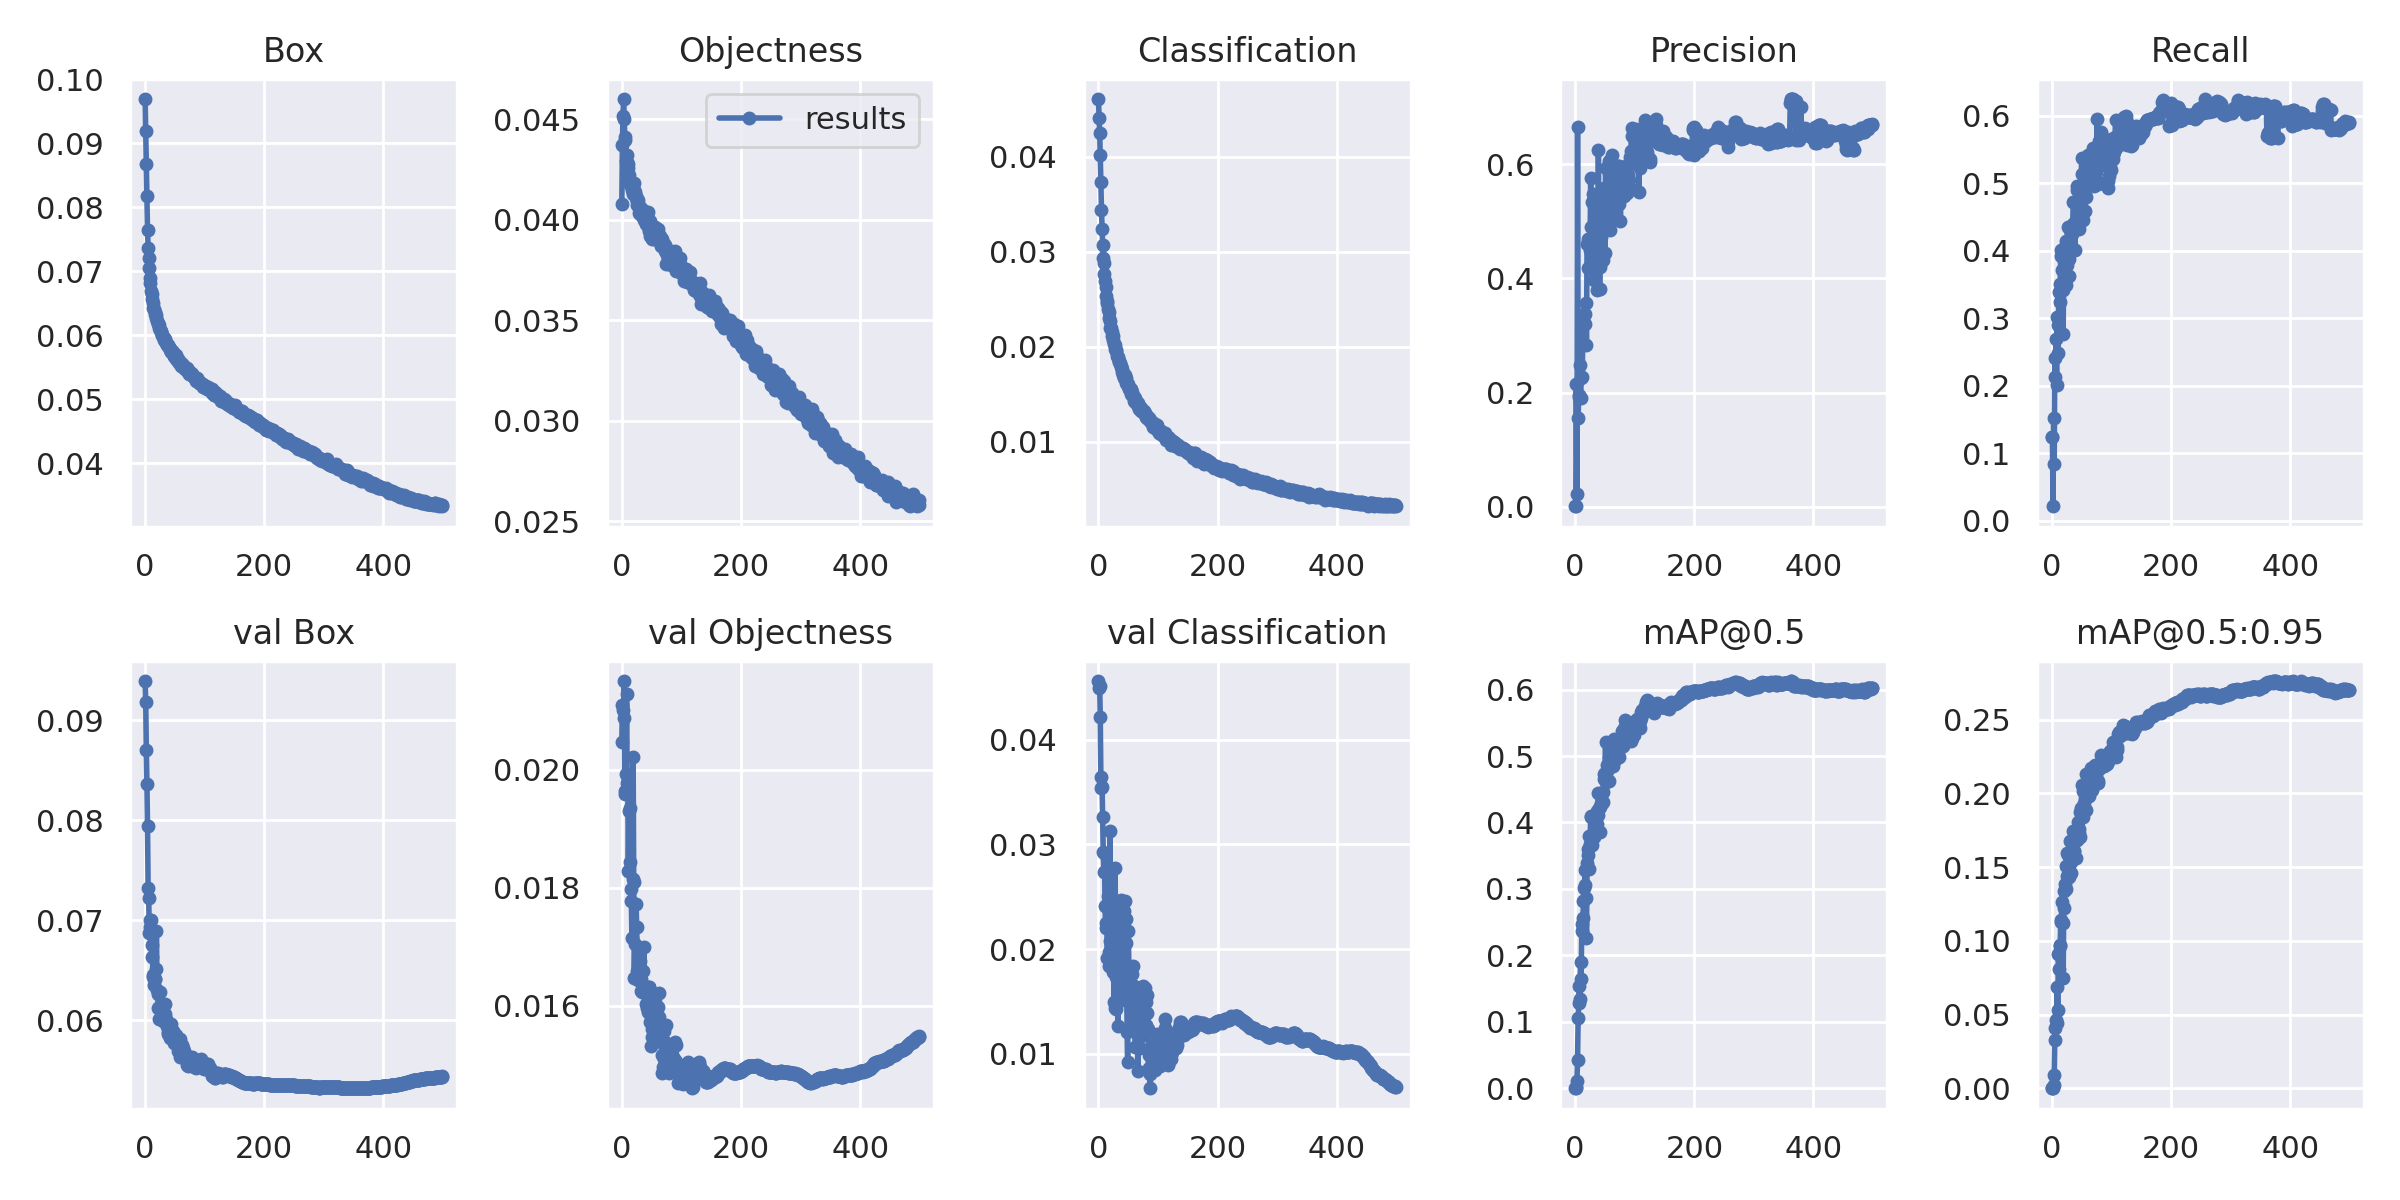

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

# Visualize Training Data

GROUND TRUTH TRAINING DATA:


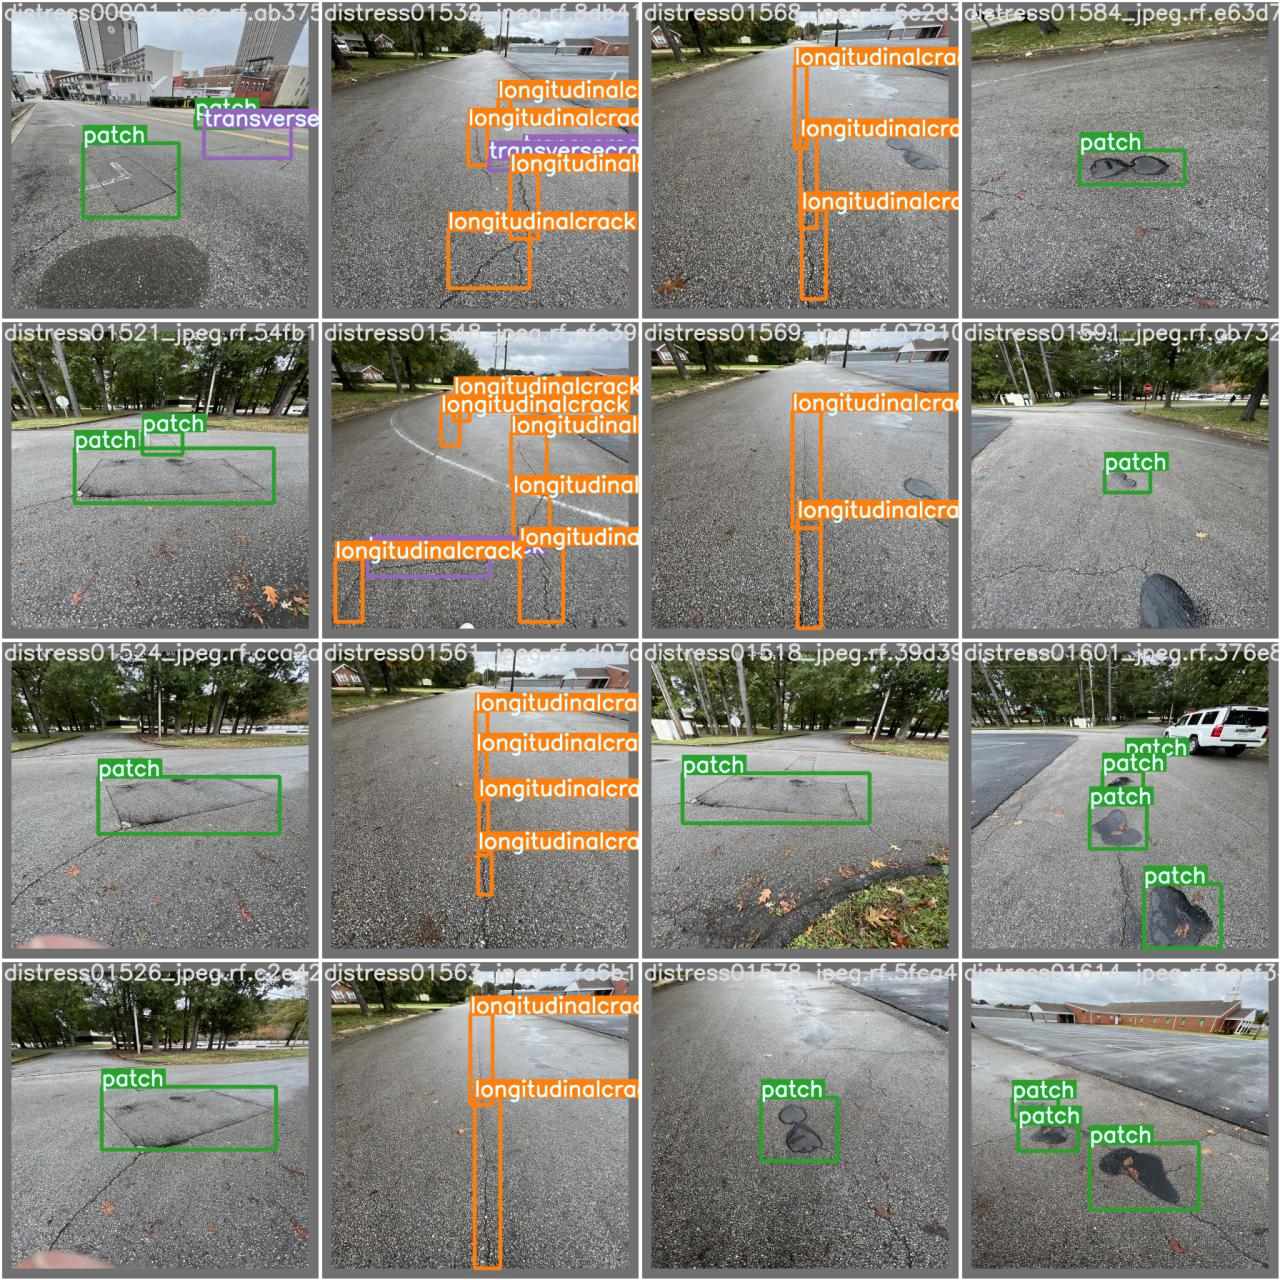

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


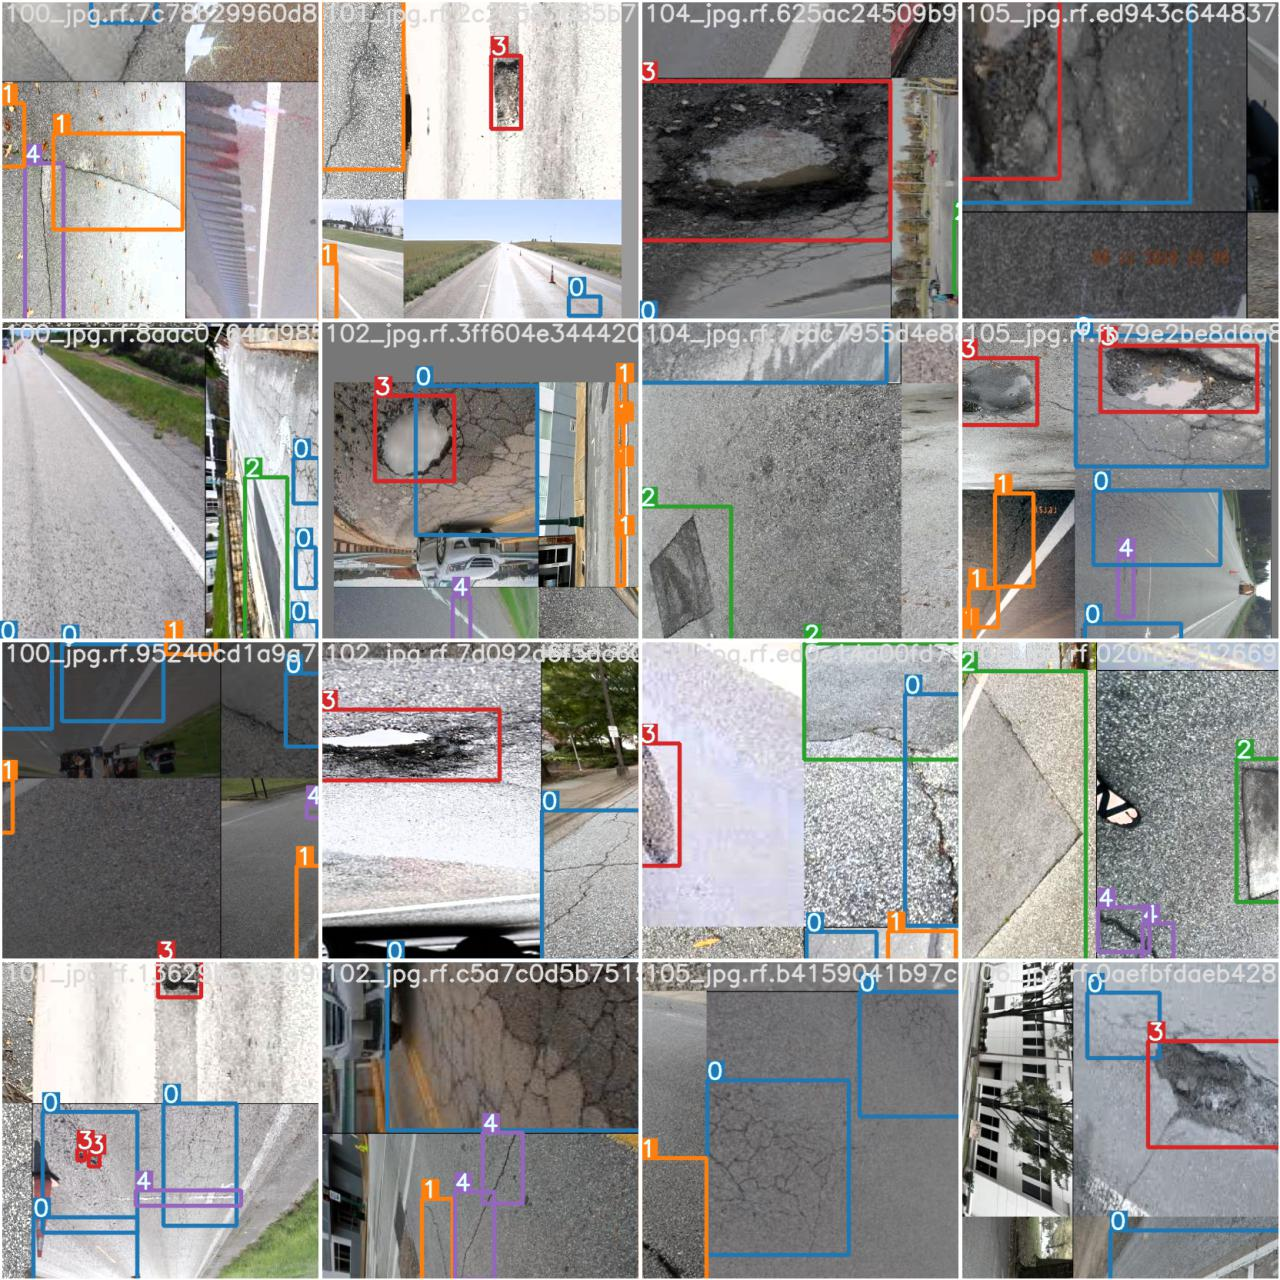

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# Run Inference

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

detect/  train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
# make sure to use correct file path for /Pavement-Distresses-n
# based on Roboflow data set version; current -11
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/Pavement-Distresses-11/test/images

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/yolov5/Pavement-Distresses-11/test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu111 CUDA:0 (Tesla V100-SXM2-16GB, 16160.5MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 232 layers, 7257306 parameters, 0 gradients, 16.8 GFLOPS
image 1/195 /content/yolov5/Pavement-Distresses-11/test/im

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

Output hidden; open in https://colab.research.google.com to view.

# Export Best Weights
This allows for inference on other devices.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/My\ Drive

# Test on Video


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMG_0980.mp4 to IMG_0980.mp4


KeyboardInterrupt: ignored

In [ ]:
!python detect.py --weights /content/gdrive/MyDrive/weights/New-Dataset/500epochs/best.pt --source /content/yolov5/IMG_0980.mp4

Traceback (most recent call last):
  File "detect.py", line 10, in <module>
    from models.experimental import attempt_load
  File "/content/yolov5/models/experimental.py", line 7, in <module>
    from models.common import Conv, DWConv
  File "/content/yolov5/models/common.py", line 7, in <module>
    import requests
  File "/usr/local/lib/python3.7/dist-packages/requests/__init__.py", line 53, in <module>
    from chardet import __version__ as chardet_version
  File "/usr/local/lib/python3.7/dist-packages/chardet/__init__.py", line 19, in <module>
    from .universaldetector import UniversalDetector
  File "/usr/local/lib/python3.7/dist-packages/chardet/universaldetector.py", line 48, in <module>
    from .sbcsgroupprober import SBCSGroupProber
  File "/usr/local/lib/python3.7/dist-packages/chardet/sbcsgroupprober.py", line 34, in <module>
    from .langhebrewmodel import WINDOWS_1255_HEBREW_MODEL
  File "/usr/local/lib/python3.7/dist-packages/chardet/langhebrewmodel.py", line 2676, 